# Boilerplate

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ensemble_boxes import *

class Colors:
    """
    https://github.com/ultralytics/yolov5/blob/master/utils/plots.py
    """
    # Ultralytics color palette https://ultralytics.com/
    def __init__(self):
        # hex = matplotlib.colors.TABLEAU_COLORS.values()
        hex = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB',
               '2C99A8', '00C2FF', '344593', '6473FF', '0018EC', '8438FF', '520085', 'CB38FF', 'FF95C8', 'FF37C7')
        self.palette = [self.hex2rgb('#' + c) for c in hex]
        self.n = len(self.palette)

    def __call__(self, i, bgr=False):
        c = self.palette[int(i) % self.n]
        return (c[2], c[1], c[0]) if bgr else c

    @staticmethod
    def hex2rgb(h):  # rgb order (PIL)
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

colors = Colors()

class Annotator:
    """
    https://github.com/ultralytics/yolov5/blob/master/utils/plots.py
    """
    # YOLOv5 Annotator for train/val mosaics and jpgs and detect/hub inference annotations
    def __init__(self, im, line_width=None, font_size=None, font='Arial.ttf', pil=False, example='abc'):
        assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to Annotator() input images.'
        self.im = im
        self.lw = line_width or max(round(sum(im.shape) / 2 * 0.003), 2)  # line width

    def box_label(self, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
        p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        cv2.rectangle(self.im, p1, p2, color, thickness=self.lw, lineType=cv2.LINE_AA)
        if label:
            tf = max(self.lw - 1, 1)  # font thickness
            w, h = cv2.getTextSize(label, 0, fontScale=self.lw / 3, thickness=tf)[0]  # text width, height
            outside = p1[1] - h - 3 >= 0  # label fits outside box
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(self.im, p1, p2, color, -1, cv2.LINE_AA)  # filled
            cv2.putText(self.im, label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2), 0, self.lw / 3, txt_color,
                        thickness=tf, lineType=cv2.LINE_AA)

    def rectangle(self, xy, fill=None, outline=None, width=1):
        # Add rectangle to image (PIL-only)
        self.draw.rectangle(xy, fill, outline, width)

    def text(self, xy, text, txt_color=(255, 255, 255)):
        # Add text to image (PIL-only)
        w, h = self.font.getsize(text)  # text width, height
        self.draw.text((xy[0], xy[1] - h + 1), text, fill=txt_color, font=self.font)

    def result(self):
        # Return annotated image as array
        return np.asarray(self.im)
    
def show_boxes(boxes, names=None, name_to_id=None, scores=None, img_size=(1000,1000), denormalized_box=True):
    im = make_image_box(boxes, names=names, name_to_id=name_to_id, scores=scores)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_ticks_position('top')
    ax.imshow(im)
    plt.show()

def make_image_box(boxes, names=None, name_to_id=None, scores=None, img_size=(1000,1000), denormalized_box=True):
    im = np.ones((img_size[0],img_size[1],3),dtype='uint8')*255
    annotator = Annotator(im)
    if denormalized_box:
        boxes = np.array(boxes) * min(img_size)
        boxes = boxes.astype(np.int32).tolist()
    if names is None:
        names = range(len(boxes))
    if name_to_id is None:
        name_to_id = {v:k for k, v in enumerate(set(names))}
    if scores is None:
        scores = [''] * len(boxes)
    else:
        scores = ["{:.2f}".format(score) for score in scores]
    for box, name, score in zip(boxes, names, scores):
        annotator.box_label(box, str(name) + '_' + score, color=colors(name_to_id[name]))
    return annotator.im

# Problem

## Multi model

In [2]:
boxes_list = [[
    [0.00, 0.51, 0.81, 0.91],
    [0.10, 0.31, 0.71, 0.61],
    [0.01, 0.32, 0.83, 0.93],
    [0.02, 0.53, 0.11, 0.94],
    [0.03, 0.24, 0.12, 0.35],
],[
    [0.04, 0.56, 0.84, 0.92],
    [0.12, 0.33, 0.72, 0.64],
    [0.38, 0.66, 0.79, 0.95],
    [0.08, 0.49, 0.21, 0.89],
]]
scores_list = [[0.9, 0.8, 0.2, 0.4, 0.7], [0.5, 0.8, 0.7, 0.3]]
labels_list = [[0, 1, 0, 1, 1], [1, 1, 1, 0]]
weights = [2, 1]

## Single model (flatten from multi model)

In [3]:
boxes_list_flat = [i_ for i in boxes_list for i_ in i]
scores_list_flat = [i_ for i in scores_list for i_ in i]
labels_list_flat = [i_ for i in labels_list for i_ in i]

# Params

In [4]:
iou_thr = 0.5
skip_box_thr = 0.0001
sigma = 0.1

# Multi model

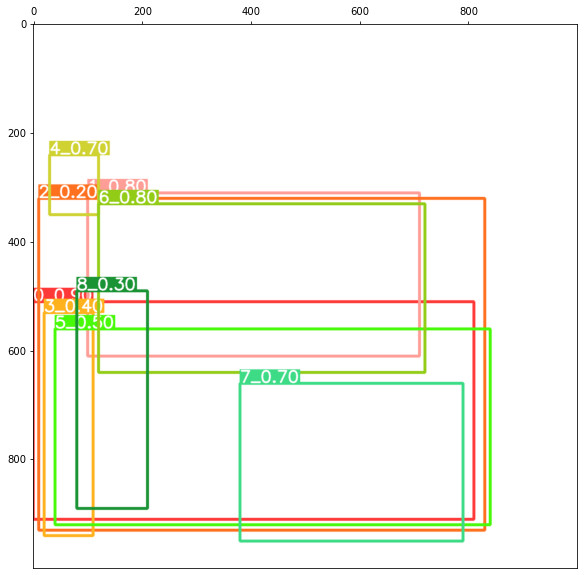

In [12]:
im_ori = make_image_box(boxes_list_flat, names=range(len(boxes_list_flat)), scores=scores_list_flat)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('top')
ax.imshow(im_ori)
plt.show()

In [6]:
# WBF
boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=0.0)
im_wbf = make_image_box(boxes, names=labels.astype(np.int32), scores=scores)

# soft-nms (gaussian)
boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, method=2, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
im_soft_nms = make_image_box(boxes, names=labels.astype(np.int32), scores=scores)

# nms
boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
im_nms = make_image_box(boxes, names=labels.astype(np.int32), scores=scores)

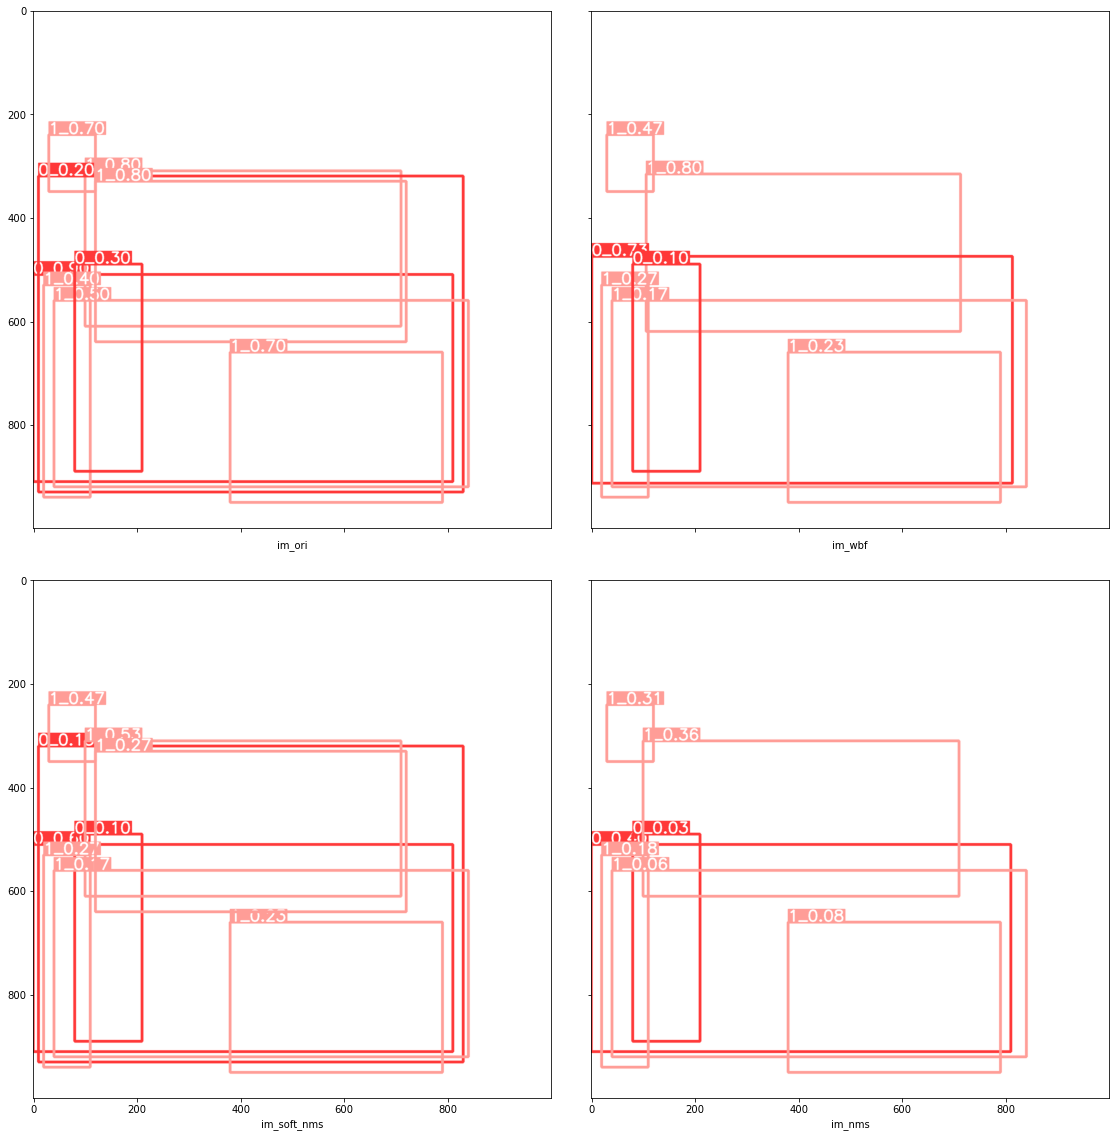

In [7]:
plt.figure(figsize=(20,20))

ax1 = plt.subplot(2,2,1)
plt.grid(False)
plt.imshow(im_ori, cmap=plt.cm.binary)
plt.xlabel('im_ori')

ax2 = plt.subplot(2,2,2, sharex = ax1)
plt.grid(False)
plt.imshow(im_wbf, cmap=plt.cm.binary)
plt.xlabel('im_wbf')

ax3 = plt.subplot(2,2,3)
plt.grid(False)
plt.imshow(im_soft_nms, cmap=plt.cm.binary)
plt.xlabel('im_soft_nms')

ax4 = plt.subplot(2,2,4)
plt.grid(False)
plt.imshow(im_nms, cmap=plt.cm.binary)
plt.xlabel('im_nms')

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax4.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.show()

# SIngle model

In [8]:
boxes_list = [
    [0.00, 0.51, 0.81, 0.91],
    [0.10, 0.31, 0.71, 0.61],
    [0.01, 0.32, 0.83, 0.93],
    [0.02, 0.53, 0.11, 0.94],
    [0.03, 0.24, 0.12, 0.35],
    [0.04, 0.56, 0.84, 0.92],
    [0.12, 0.33, 0.72, 0.64],
    [0.38, 0.66, 0.79, 0.95],
    [0.08, 0.49, 0.21, 0.89],
]
scores_list = [0.9, 0.8, 0.2, 0.4, 0.7, 0.5, 0.8, 0.7, 0.3]
labels_list = [0, 1, 0, 1, 1, 1, 1, 1, 0]

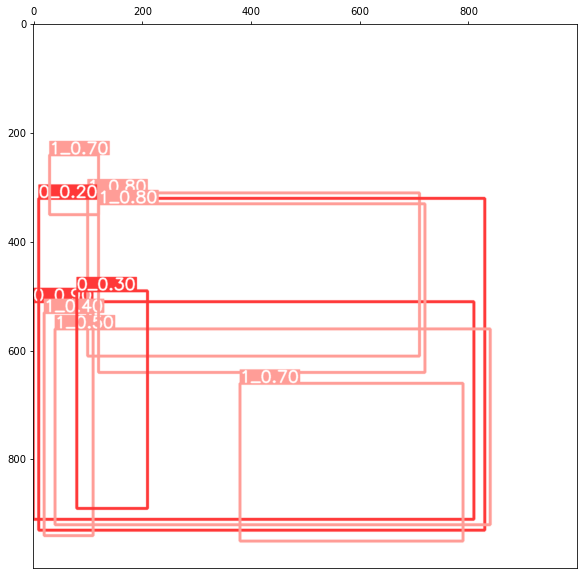

In [9]:
im_ori = make_image_box(boxes_list_flat, names=labels_list_flat, scores=scores_list_flat)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('top')
ax.imshow(im_ori)
plt.show()

In [10]:
# WBF
boxes, scores, labels = weighted_boxes_fusion([boxes_list_flat], [scores_list_flat], [labels_list_flat], weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
im_wbf = make_image_box(boxes, names=labels.astype(np.int32), scores=scores)

# soft-nms (gaussian)
boxes, scores, labels = soft_nms([boxes_list_flat], [scores_list_flat], [labels_list_flat], method=2, weights=None, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
im_soft_nms = make_image_box(boxes, names=labels.astype(np.int32), scores=scores)

# nms
boxes, scores, labels = nms([boxes_list_flat], [scores_list_flat], [labels_list_flat], weights=None, iou_thr=iou_thr)
im_nms = make_image_box(boxes, names=labels.astype(np.int32), scores=scores)

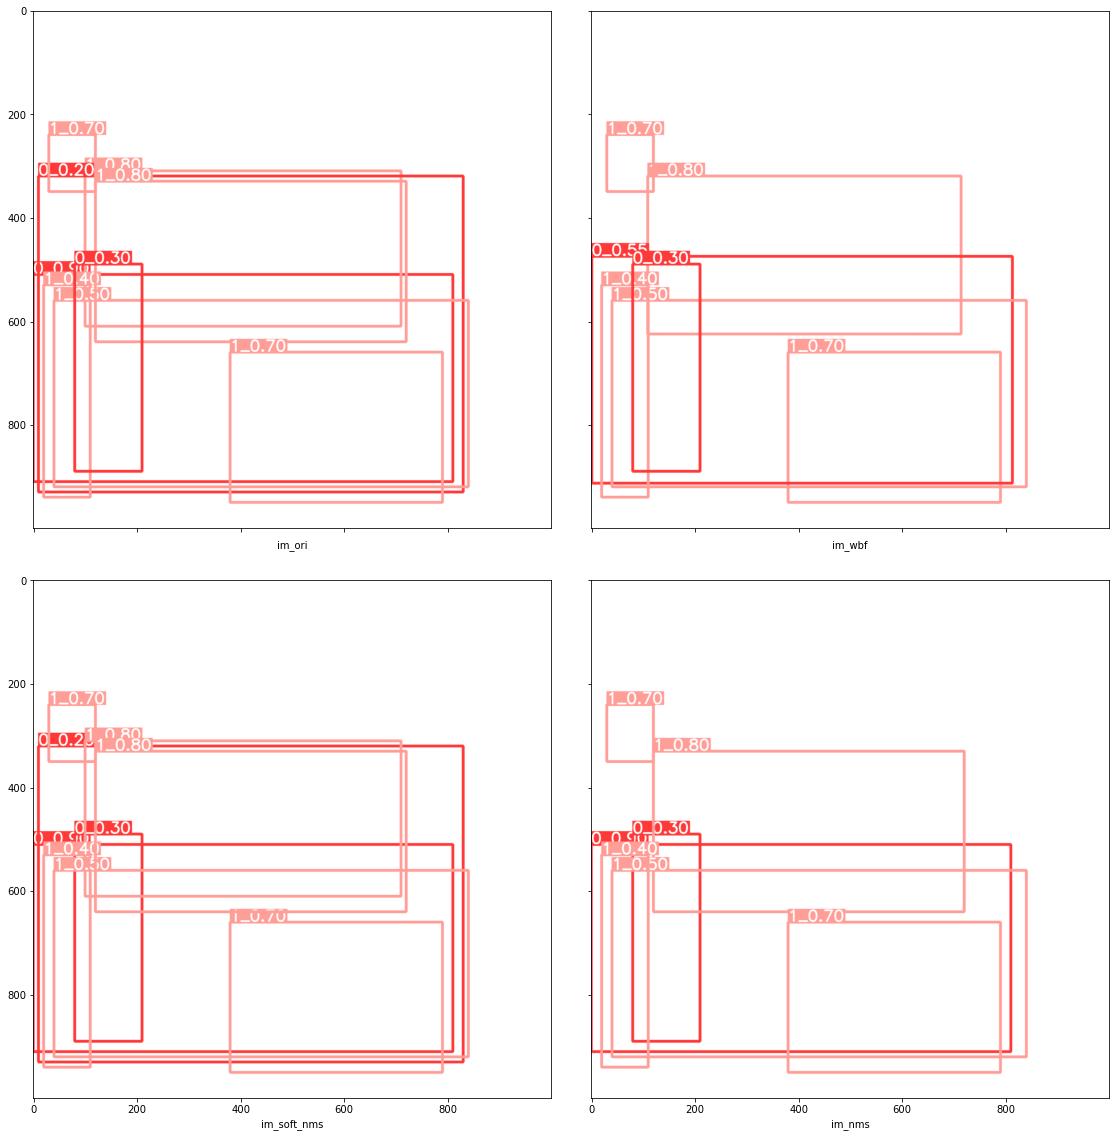

In [11]:
plt.figure(figsize=(20,20))

ax1 = plt.subplot(2,2,1)
plt.grid(False)
plt.imshow(im_ori, cmap=plt.cm.binary)
plt.xlabel('im_ori')

ax2 = plt.subplot(2,2,2, sharex = ax1)
plt.grid(False)
plt.imshow(im_wbf, cmap=plt.cm.binary)
plt.xlabel('im_wbf')

ax3 = plt.subplot(2,2,3)
plt.grid(False)
plt.imshow(im_soft_nms, cmap=plt.cm.binary)
plt.xlabel('im_soft_nms')

ax4 = plt.subplot(2,2,4)
plt.grid(False)
plt.imshow(im_nms, cmap=plt.cm.binary)
plt.xlabel('im_nms')

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax4.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.show()